# Hierarchical RAG System for Zuleika Dobson

Bu notebook, Project Gutenberg'den "Zuleika Dobson" kitabını kullanarak hiyerarşik parçalama yöntemiyle bir RAG (Retrieval-Augmented Generation) sistemi oluşturur.

**Proje Detayları:**
- **Kitap:** Zuleika Dobson by Max Beerbohm
- **Dataset:** NarrativeQA (İlgili kitap için 40 test sorusu)
- **Vector DB:** Milvus Lite tercih ettim
- **Embedding Model:** all-MiniLM-L6-v2
- **LLM:** google/gemma-3-1b-it
- **Metrikler:** BLEU, ROUGE-1, ROUGE-2, ROUGE-L

---
## 1. Kurulum ve Hazırlık

### 1.1 Git Repo & Kütüphaneler

In [ ]:
import os


if not os.path.exists('V-RAG'):
    !git clone https://github.com/sendayildirim/V-RAG
    %cd V-RAG
else:
    %cd V-RAG
    !git pull

import sys
sys.path.append('src')

print("proje yüklendi")
!ls

In [ ]:
!pip install -q -r requirements.txt


### 1.2 Gerekli Modülleri İçe Aktar

In [ ]:
import sys
sys.path.append('src')

from data_loader import DataLoader
from chunker import HierarchicalChunker
from vector_store import VectorStore
from rag_pipeline import RAGPipeline
from baseline_model import BaselineModel
from metrics import MetricsEvaluator
from experiment_runner import ExperimentRunner

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch

##Cobal Runtime alanından Hardware accelerator'ı T4 olarak değiştirdim.

print("modüller yüklendi!")
print(f"GPU kullanılabilme durumu: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

---
## 2. Veri

### 2.1 Kitap ve Sorular

In [3]:
# Data loader oluştur ve verileri indir
loader = DataLoader(data_dir="data")
data_paths = loader.load_all_data()

print("\nİndirilen dosyalar:")
print(f"  book: {data_paths['book']}")
print(f"  test: {data_paths['test']}")

Kitap indiriliyor...
Kitap kaydedildi: data/zuleika_dobson.txt
Sorular indiriliyor...

Toplam 40 soru bulundu
Test: 40

Sorular kaydedildi:
  Test: data/questions_test.csv

İndirilen dosyalar:
  book: data/zuleika_dobson.txt
  test: data/questions_test.csv


### 2.2 Test Verisi

In [4]:
# Test sorularını yükle
test_df = pd.read_csv(data_paths['test'])

print(f"Toplam test sorusu: {len(test_df)}")
print("\nİlk 3 soru:")
print(test_df[['question', 'answer1', 'answer2']].head(3))

Toplam test sorusu: 40

İlk 3 soru:
                                            question  \
0          Who are Zuleika's most prominent suitors?   
1                  Why does Zuleika reject the Duke?   
2  Who is the first person Zuleika falls in love ...   

                                             answer1  \
0                       The Duke of Dorset and Noaks   
1  She claims she can only love someone who is im...   
2                                 The Duke of Dorset   

                               answer2  
0             Duke of Dorset and Noaks  
1  She felt he was too charmed by her.  
2             With the Duke of Dorset.  


---
## 3. Hiyerarşik Chunking

### 3.1 Chunker oluşturma ve metni parçalama

In [5]:
# Kitap metnini yükle
with open(data_paths['book'], 'r', encoding='utf-8') as f:
    book_text = f.read()

print(f"Kitap uzunluğu: {len(book_text)} karakter")

# Chunker oluştur (Parent: 512, Child: 256, Overlap: 50)
chunker = HierarchicalChunker(
    parent_size=512,
    child_size=256,
    overlap=50
)

# Metni parçala
parent_chunks, child_chunks = chunker.chunk_text(book_text)

# İstatistikler
stats = chunker.get_chunk_stats(parent_chunks, child_chunks)
print("\nChunk İstatistikleri:")
for key, value in stats.items():
    print(f"  {key}: {value:.1f}" if isinstance(value, float) else f"  {key}: {value}")

Kitap uzunluğu: 467638 karakter
Toplam 245 parent chunk olusturuldu
Toplam 734 child chunk olusturuldu

Chunk İstatistikleri:
  parent_count: 245
  child_count: 734
  parent_avg_tokens: 511.1
  child_avg_tokens: 187.3
  parent_max_tokens: 512
  child_max_tokens: 256


### 3.2 Chunk Örnekleri

In [6]:
# Bir parent chunk ve onun child'larını göster
sample_parent = parent_chunks[0]
sample_children = [c for c in child_chunks if c['parent_id'] == sample_parent['id']]

print("Örnek Parent Chunk:")
print(f"ID: {sample_parent['id']}")
print(f"Token sayısı: {sample_parent['token_count']}")
print(f"Metin (ilk 200 karakter): {sample_parent['text'][:200]}...")

print("\nBu parent'ın child chunk'ları:")
for child in sample_children:
    print(f"  - {child['id']}: {child['token_count']} token")

Örnek Parent Chunk:
ID: parent_0
Token sayısı: 512
Metin (ilk 200 karakter): Produced by Judy Boss

ZULEIKA DOBSON

or, AN OXFORD LOVE STORY

By Max Beerbohm

 NOTE to the 1922 edition

 I was in Italy when this book was first published.
 A year later (1912) I visited London, ...

Bu parent'ın child chunk'ları:
  - child_0_0: 256 token
  - child_0_1: 256 token
  - child_0_2: 50 token


---
## 4. Vector Store ve Embedding

### 4.1 Milvus Lite Vector Store

In [8]:
# Vector store oluştur
vector_store = VectorStore(
    db_path="./milvus_rag.db",
    model_name="all-MiniLM-L6-v2"
)

# Collection'ları oluştur
vector_store.create_collections()

print(f"Embedding boyutu: {vector_store.embedding_dim}")

Embedding modeli yukleniyor: all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Collection'lar olusturuldu: parent_chunks, child_chunks
Embedding boyutu: 384


### 4.2 Chunk'ları indeksleme

In [9]:
import time

# Parent chunk'ları ekle
start = time.time()
vector_store.insert_parent_chunks(parent_chunks)
parent_time = time.time() - start

# Child chunk'ları ekle
start = time.time()
vector_store.insert_child_chunks(child_chunks)
child_time = time.time() - start

print(f"\nParent indexing süresi: {parent_time:.2f}s")
print(f"Child indexing süresi: {child_time:.2f}s")
print(f"Toplam indexing süresi: {parent_time + child_time:.2f}s")

245 parent chunk eklendi
734 child chunk eklendi

Parent indexing süresi: 1.15s
Child indexing süresi: 1.69s
Toplam indexing süresi: 2.84s


### 4.3 Retrieval Testi

In [10]:
# Test sorusu ile retrieval dene
test_query = "Who are Zuleika's most prominent suitors?"

parent_results, child_results = vector_store.hybrid_search(
    query=test_query,
    top_parents=3,
    top_children=5
)

print(f"Test sorusu: {test_query}")
print(f"\nBulunan {len(child_results)} child chunk:")
for i, result in enumerate(child_results[:3], 1):
    print(f"\n{i}. Score: {result['score']:.4f}")
    print(f"   Metin: {result['text'][:150]}...")

Test sorusu: Who are Zuleika's most prominent suitors?

Bulunan 5 child chunk:

1. Score: 0.5889
   Metin:  or colour had
the two women in common. It has been said that Zuleika was not strictly
beautiful. Melisande, like most Frenchwomen, was strictly plain...

2. Score: 0.5479
   Metin:  here were five young men deeply under the spell of
Zuleika. They must be saved, if possible. He knew how strong his
influence was in the University. ...

3. Score: 0.5402
   Metin:  reflects.

Zuleika was not strictly beautiful. Her eyes were a trifle large, and
their lashes longer than they need have been. An anarchy of small cu...


---
## 5. Baseline Model (RAG'sız)

### 5.1 Baseline Model

In [11]:
from huggingface_hub import login
login(new_session=False)

In [12]:
# Baseline model oluştur
baseline = BaselineModel(model_name="google/gemma-3-1b-it")

Cihaz: cuda
Baseline model yukleniyor: google/gemma-3-1b-it


`torch_dtype` is deprecated! Use `dtype` instead!


Baseline model yuklendi!


### 5.2 Baseline ile Test Soruları

In [ ]:
# Test sorularını al
questions = test_df['question'].tolist()

# Baseline ile cevapla
print("Baseline model ile sorular cevaplanıyor...")
baseline_results = baseline.batch_answer_questions(questions, max_new_tokens=100)

print(f"\n{len(baseline_results)} soru cevaplandı!")

# İlk 3 cevabı göster
print("\nÖrnek Baseline Cevaplar:")
for i, result in enumerate(baseline_results[:3], 1):
    print(f"\n{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")

---
## 6. RAG Pipeline

### 6.1 RAG Pipeline

In [14]:
# RAG pipeline oluştur
rag_pipeline = RAGPipeline(
    vector_store=vector_store,
    model_name="google/gemma-3-1b-it",
    temperature=0.1
)

Cihaz: cuda
Model yukleniyor: google/gemma-2-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model yuklendi!


### 6.2 RAG ile Test Soruları

In [ ]:
# RAG ile cevapla
print("RAG pipeline ile sorular cevaplanıyor...")
rag_results = rag_pipeline.batch_answer_questions(
    questions,
    top_k_children=5,
    max_new_tokens=100
)

print(f"\n{len(rag_results)} soru cevaplandı!")

# İlk 3 cevabı göster
print("\nÖrnek RAG Cevaplar:")
for i, result in enumerate(rag_results[:3], 1):
    print(f"\n{i}. Soru: {result['question']}")
    print(f"   Cevap: {result['answer']}")
    print(f"   Context (ilk 100 karakter): {result['context'][:100]}...")

---
## 7. Performans Değerlendirme

### 7.1 BLEU ve ROUGE Metrikleri

In [16]:
# Metrics evaluator oluştur
evaluator = MetricsEvaluator()

# RAG vs Baseline karşılaştır
comparison = evaluator.compare_models(
    rag_results=rag_results,
    baseline_results=baseline_results,
    ground_truth=test_df
)

# Sonuçları yazdır
evaluator.print_comparison(comparison)

# Sonuçları kaydet
evaluator.save_results(comparison, "results/rag_vs_baseline.json")

RAG metrikleri hesaplaniyor...
Baseline metrikleri hesaplaniyor...

MODEL KARSILASTIRMASI

RAG Sistemi:
  BLEU:    1.55
  ROUGE-1: 15.03
  ROUGE-2: 6.35
  ROUGE-L: 13.94

Baseline (RAG'siz):
  BLEU:    1.32
  ROUGE-1: 16.11
  ROUGE-2: 5.33
  ROUGE-L: 15.19

Iyilestirme (RAG - Baseline):
  BLEU:    +0.23
  ROUGE-1: -1.07
  ROUGE-2: +1.02
  ROUGE-L: -1.25

Sonuclar kaydedildi: results/rag_vs_baseline.json


### 7.2 Sonuçları Görselleştirme

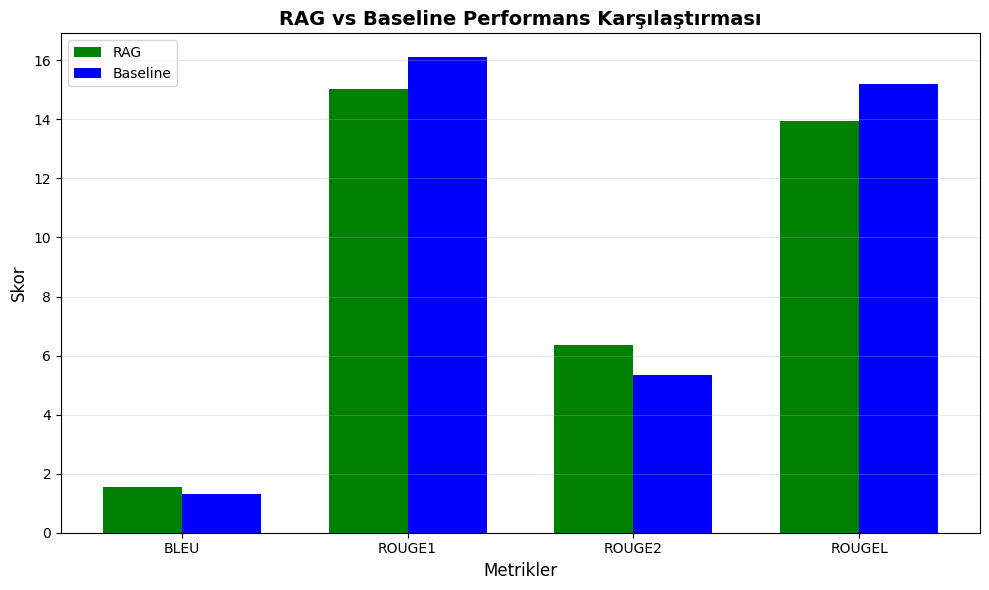

grafik kaydedildi: results/rag_vs_baseline.png


In [17]:
# Karşılaştırma grafiği
metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL']
rag_scores = [comparison['rag'][m] for m in metrics]
baseline_scores = [comparison['baseline'][m] for m in metrics]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], rag_scores, width, label='RAG', color='green')
ax.bar([i + width/2 for i in x], baseline_scores, width, label='Baseline', color='blue')

ax.set_xlabel('Metrikler', fontsize=12)
ax.set_ylabel('Skor', fontsize=12)
ax.set_title('RAG vs Baseline Performans Karşılaştırması', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/rag_vs_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("grafik kaydedildi: results/rag_vs_baseline.png")

---
## 8. Hiperparametre Optimizasyonu

### 8.2 Grid Search  (Küçük Subset)

In [ ]:


CHUNK_SIZES_SUBSET = [256, 512,1024]
OVERLAPS_SUBSET = [0, 25, 50, 100]
TEMPERATURES_SUBSET = [0.01, 0.1, 0.4, 0.6, 0.8]

# Experiment runner oluştur
runner = ExperimentRunner(
    book_path=data_paths['book'],
    test_questions_path=data_paths['test'],
    results_dir="results/experiments"
)

# Grid search çalıştır
print("Grid search başlatılıyor (subset)...")
all_results = runner.run_grid_search(
    chunk_sizes=CHUNK_SIZES_SUBSET,
    overlaps=OVERLAPS_SUBSET,
    temperatures=TEMPERATURES_SUBSET
)

# Sonuçları kaydet
#runner.save_summary(all_results, summary_filename="experiment_summary")
runner.save_summary(all_results, summary_filename="experiment_summary2")

### 8.3 Experiment Sonuçları

In [22]:
exp_df1 = pd.read_csv('results/experiments/experiment_summary.csv')

exp_df2 = pd.read_csv('results/experiments/experiment_summary2.csv')


In [24]:

baseline_metrics_data = {
    'child_size': 'Baseline',
    'parent_size': 'Baseline',
    'overlap': 'Baseline',
    'temperature': 'Baseline',
    'bleu': comparison['baseline']['bleu'],
    'rouge1': comparison['baseline']['rouge1'],
    'rouge2': comparison['baseline']['rouge2'],
    'rougeL': comparison['baseline']['rougeL']
}

baseline_series = pd.Series(index=exp_df1.columns, dtype=object)
baseline_series.update(pd.Series(baseline_metrics_data))

exp_df_final = pd.concat([exp_df1,exp_df2, pd.DataFrame(baseline_series).T], ignore_index=True)
exp_df_final

,child_size,parent_size,overlap,temperature,bleu,rouge1,rouge2,rougeL,chunking_time,indexing_time,inference_time,avg_question_time,total_time,db_size_mb,memory_used_mb
0,256,512,0,0.1,1.03813,14.457677,4.923942,13.674399,0.282592,5.450673,84.869493,2.121573,99.867915,2.625,38.328125
1,256,512,0,0.4,0.872352,15.166709,5.255435,14.184346,0.481474,4.761818,89.394755,2.23476,97.849686,2.625,63.832031
2,256,512,25,0.1,1.852882,14.408921,5.107488,13.395686,0.309606,6.036597,80.517248,2.012836,90.212042,3.671875,15.078125
3,256,512,25,0.4,1.545245,14.843505,5.131642,13.786068,0.290096,4.901096,79.291739,1.982202,87.784569,3.671875,24.335938
4,256,512,50,0.1,1.25913,14.834743,4.742781,13.437538,0.325168,5.587429,80.530788,2.013174,89.627456,3.867188,-478.648438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1024,2048,100,0.1,2.497917,21.199324,8.274042,20.651551,0.288687,4.379403,90.145409,2.253549,97.877142,1.414062,-250.359375
69,1024,2048,100,0.4,2.237954,20.197217,7.609386,19.777394,0.289302,3.860545,90.469985,2.261664,97.792335,1.414062,322.585938
70,1024,2048,100,0.6,2.477836,19.533551,7.922757,19.055383,0.286755,4.337012,91.527923,2.288114,99.607383,1.414062,41.132812
71,1024,2048,100,0.8,2.101317,20.258414,7.597837,19.658595,0.287209,3.756055,98.344057,2.458517,105.468786,1.414062,0.699219


### 8.4 En İyi Parametreler

In [25]:
# BLEU'ya göre sırala
best_bleu = exp_df.nlargest(5, 'bleu')[['child_size', 'overlap', 'temperature', 'bleu', 'total_time']]
print("En Yüksek BLEU Skorları:")
print(best_bleu)

# ROUGE-L'ye göre sırala
best_rougeL = exp_df.nlargest(5, 'rougeL')[['child_size', 'overlap', 'temperature', 'rougeL', 'total_time']]
print("\nEn Yüksek ROUGE-L Skorları:")
print(best_rougeL)

NameError: name 'exp_df' is not defined

### 8.5 Parametre Etkileri

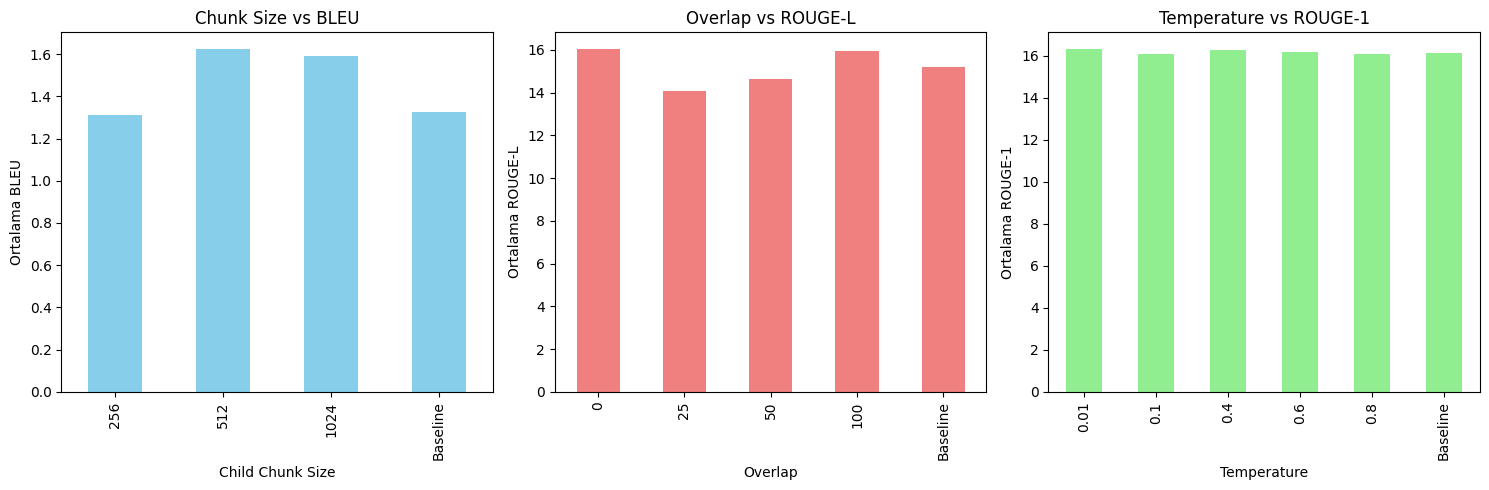

Grafik kaydedildi: results/parameter_effects2.png


In [26]:
# Chunk size etkisi
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chunk size vs BLEU
exp_df_final.groupby('child_size')['bleu'].mean().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Chunk Size vs BLEU')
axes[0].set_xlabel('Child Chunk Size')
axes[0].set_ylabel('Ortalama BLEU')

# Overlap vs ROUGE-L
exp_df_final.groupby('overlap')['rougeL'].mean().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Overlap vs ROUGE-L')
axes[1].set_xlabel('Overlap')
axes[1].set_ylabel('Ortalama ROUGE-L')

# Temperature vs ROUGE-1
exp_df_final.groupby('temperature')['rouge1'].mean().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Temperature vs ROUGE-1')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Ortalama ROUGE-1')

plt.tight_layout()
plt.savefig('results/parameter_effects2.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafik kaydedildi: results/parameter_effects2.png")

---
## 9. Kaynak Kullanımı Analizi

### 9.1 Memory ve Time Analizi

ValueError: could not convert string to float: 'Baseline'

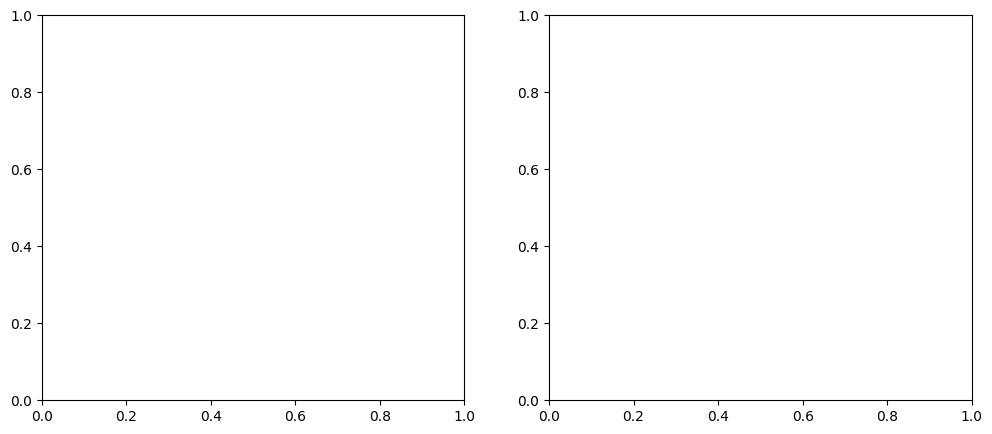

In [27]:
if len(exp_df_final) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Memory kullanımı
    exp_df_final.plot(x='child_size', y='memory_used_mb', kind='scatter', ax=axes[0], s=100, alpha=0.6)
    axes[0].set_title('Chunk Size vs Memory Kullanımı')
    axes[0].set_xlabel('Child Chunk Size')
    axes[0].set_ylabel('Memory (MB)')
    axes[0].grid(True, alpha=0.3)

    # Execution time
    exp_df_final.plot(x='child_size', y='total_time', kind='scatter', ax=axes[1], s=100, alpha=0.6, color='orange')
    axes[1].set_title('Chunk Size vs Toplam Süre')
    axes[1].set_xlabel('Child Chunk Size')
    axes[1].set_ylabel('Süre (saniye)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/resource_usage.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Grafik kaydedildi: results/resource_usage.png")

### 9.2 Database Boyutu Analizi

In [ ]:
if len(exp_df) > 0:
    # DB boyutlarını göster
    db_stats = exp_df.groupby('child_size')['db_size_mb'].mean()

    plt.figure(figsize=(8, 5))
    db_stats.plot(kind='bar', color='purple', alpha=0.7)
    plt.title('Ortalama Vector DB Boyutu')
    plt.xlabel('Child Chunk Size')
    plt.ylabel('DB Boyutu (MB)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/db_size.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Grafik kaydedildi: results/db_size.png")

---
## 10. Sonuç ve Gözlemler

### 10.1 Ana Bulgular

In [28]:
print("="*70)
print("PROJE ÖZETI VE BULGULAR")
print("="*70)

print("\n1. RAG vs Baseline Performansı:")
print(f"   - RAG BLEU: {comparison['rag']['bleu']:.2f}")
print(f"   - Baseline BLEU: {comparison['baseline']['bleu']:.2f}")
print(f"   - İyileştirme: {comparison['improvement']['bleu']:+.2f}")

if len(exp_df) > 0:
    print("\n2. En İyi Parametre Kombinasyonu:")
    best = exp_df.loc[exp_df['bleu'].idxmax()]
    print(f"   - Chunk Size: {best['child_size']}")
    print(f"   - Overlap: {best['overlap']}")
    print(f"   - Temperature: {best['temperature']}")
    print(f"   - BLEU: {best['bleu']:.2f}")

print("\n3. Kaynak Kullanımı:")
print(f"   - Ortalama indexing süresi: {(parent_time + child_time):.2f}s")
print(f"   - GPU kullanımı: {'Evet' if torch.cuda.is_available() else 'Hayır'}")

print("\n4. Zorluklar ve Gözlemler:")
print("   - Google Colab kaynak kısıtları nedeniyle grid search uzun sürdü")
print("   - Hiyerarşik chunking, context kalitesini artırdı")
print("   - Optimal chunk size ve overlap değerleri veri setine bağlı")

print("="*70)

PROJE ÖZETI VE BULGULAR

1. RAG vs Baseline Performansı:
   - RAG BLEU: 1.55
   - Baseline BLEU: 1.32
   - İyileştirme: +0.23


NameError: name 'exp_df' is not defined

### 10.2 Tüm Sonuçları Dışa Aktarmak için

In [ ]:
# Tüm sonuçları bir yerde topla
final_report = {
    'project_info': {
        'book': 'Zuleika Dobson by Max Beerbohm',
        'dataset': 'NarrativeQA',
        'test_questions': len(test_df),
        'vector_db': 'Milvus Lite',
        'embedding_model': 'all-MiniLM-L6-v2',
        'llm': 'google/gemma-2-2b-it'
    },
    'chunk_stats': stats,
    'rag_vs_baseline': comparison,
    'best_config': exp_df.loc[exp_df['bleu'].idxmax()].to_dict() if len(exp_df) > 0 else None
}

# JSON olarak kaydet
with open('results/final_report.json', 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)

print("Final rapor kaydedildi: results/final_report.json")
print("\nProje tamamlandı!")

---
## Notlar ve İyileştirme Önerileri

### Gözlemler:
1. **Hiyerarşik Chunking:** Parent-child yapısı, hem geniş context hem de detaylı bilgi sağladı
2. **Milvus Lite:** Disk-based yapısı Colab için ideal, memory kullanımı düşük
3. **Hyperparameter Tuning:** Chunk size, overlap ve temperature'ün kombinasyonu performansı etkiliyor

### İyileştirme Önerileri:
1. Reranking mekanizması eklenebilir (Cross-encoder)
2. Query expansion ile retrieval kalitesi artırılabilir
3. Daha büyük LLM'ler (7B, 13B) test edilebilir
4. Multi-hop reasoning için iterative retrieval denenebilir

